In [ ]:
from nbdev import *
%nbdev_hide_input
%load_ext autoreload
%autoreload 2
!date

Sat Apr 24 12:54:07 PDT 2021


# B1259-63 phased analysis
> Rebin with time bins aligned with orbit

Choose 1000 bins/orbit.

In [ ]:
%nbdev_collapse_input
from wtlike.config import *
from wtlike.bayesian import *
from wtlike.lightcurve import *
from light_curves.b1259 import *

config = Config(data_folder='/home/burnett/weekly', verbose=1)

class B1259phased(B1259Periastron):
    def __init__(self, config, first=54683, last=59326, nbins=1000, clear=False):
        
        # construct bins with respect to phase
        interval=nbins/self.period
        def mjd2phase_bin(mjd):
            return (mjd-self.tp+self.period)*interval
        def phase_bin2mjd(pb):
            return pb/interval+self.tp-self.period
        first_edge = int(mjd2phase_bin(first))+1
        last_edge = int(mjd2phase_bin(last))
        N = last_edge-first_edge
        bins = np.array(list(map(phase_bin2mjd, np.linspace(first_edge, last_edge, N+1) )) )     
        super().__init__(config, bins=bins,bin_key='B1259_phase_bin_edges', clear=clear)
        
    def mjd2phase(self, t):
        """return the phase, [-0.5,0.5) for t in MJD """
        r = np.mod(t-self.tp, self.period)/self.period
        if r>0.5: r-=1.0
        return r
    
    def combine_phases(self):
        """ return DataFrame of cells combined with respect to phase  
        """
        cells = self.cells
        cells.loc[:,'phase'] = cells.t.apply(lambda t: self.mjd2phase(t).round(4))

        # check how many of  each phase
        if self.config.verbose>0:
            t, c = np.unique(cells.phase, return_counts=True)
            n, c = np.unique(c, return_counts=True)
            fdf = pd.DataFrame(dict(cells=n, count=c))
            print(f'Combine to {len(t)} phase cells: check number of cells \n {fdf}')

        # group by phase
        gcells = cells.groupby('phase')

        phased_cells = []
        for phase, gcell in gcells:
            newcell=dict(t=phase*self.period)
            for col in ' n e S B'.split():
                newcell[col] = gcell[col].sum()
            newcell['w'] = np.concatenate(list(gcell.w.values))
            newcell['tw']=1 
            phased_cells.append(newcell)
        df = pd.DataFrame(phased_cells)
        return df

photons and exposure for PSR_B1259-63: Restoring from cache with key "PSR_B1259-63_weekly_data"
Loaded 3622 / 3622 cells with exposure > 0.3 for light curve analysis
B1259_phase_bin_edges: Restoring from cache with key "B1259_phase_bin_edges"
Partitioned 3622 cells into 26 blocks, using LikelihoodFitness 
Loaded 26 / 26 cells with exposure > 0.3 for fitting
Combine to 1000 phase cells: check number of cells 
    cells  count
0      2     68
1      3    242
2      4    690
Loaded 1000 / 1000 cells with exposure > 0.3 for light curve analysis


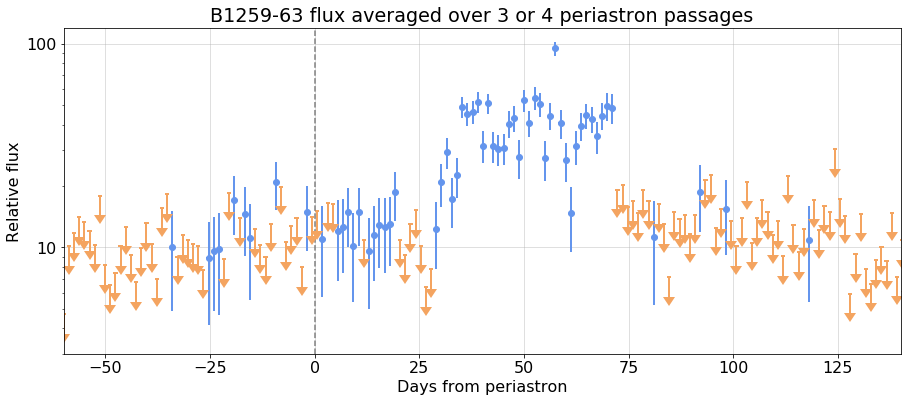

In [ ]:
%nbdev_collapse_input
plt.rc('font', size=16)
bba = B1259phased(config)

df = bba.combine_phases()
lc = LightCurve(config, df, bba.source)

fig, ax = plt.subplots(figsize=(15,6))
ax.axvline(0, color='grey', ls='--')
lc.plot(ax=ax, xlim=(-60,140), ylim=(3,120), yscale='log', ts_min=4,
            xlabel='Days from periastron', ylabel='Relative flux', fmt='o',
            title='B1259-63 flux averaged over periastron passages',
           )